<a href="https://colab.research.google.com/github/purvaingle/Identification-of-Frost-in-Martian-HiRISE-Images/blob/main/v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Identification of Frost in Martian HiRISE Images1

#### Importing libraries

In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import zipfile
import random
import tensorflow as tf
from PIL import Image
import cv2
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !wget -O /content/drive/MyDrive/Colab\ Notebooks/project/data2.zip http://dataverse.jpl.nasa.gov/api/access/datafile/83039



URL transformed to HTTPS due to an HSTS policy
--2023-12-06 02:48:39--  https://dataverse.jpl.nasa.gov/api/access/datafile/83039
Resolving dataverse.jpl.nasa.gov (dataverse.jpl.nasa.gov)... 128.149.107.132
Connecting to dataverse.jpl.nasa.gov (dataverse.jpl.nasa.gov)|128.149.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2738356883 (2.5G) [application/zip]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/project/data2.zip’

/content/drive/MyDr 100%[===================>]   2.55G  24.0MB/s    in 1m 57s  

2023-12-06 02:50:37 (22.3 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/project/data2.zip’ saved [2738356883/2738356883]



1. (a) Importing the dataset


In [ ]:
# import zipfile
# import os

# zip_path = '/content/drive/MyDrive/Colab Notebooks/project/data2.zip'  # Path to your downloaded zip file
# extracted_path = '/content/drive/MyDrive/Colab Notebooks/project/dataset2'  # Destination directory for extracted files

# # Create the directory to extract files if it doesn't exist
# os.makedirs(extracted_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_path)


1.(b) Data Exploration and Pre-processing

In [ ]:
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/Colab Notebooks/project/dataset/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [ ]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/project/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/project/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/project/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

Image loading + preprocessing(1. (b)) + data augmentation (1. (c) i.)

For data augmentation, I randomly perform 3 data augmentation techniques on each image, and towards the end, out of my entire augmented dataset, I am only choosing 5585 samples and then combining it with the original dataset.

In [ ]:
def load_and_preprocess2(img_loc, label):
    def _augment_image(img):
      # print("hi im inside augment fn")


      augmentation_functions = [
        lambda img: cv2.resize(img, (299, 299)),
        lambda img: cv2.warpAffine(img, cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), np.random.randint(-30, 30), 1), (img.shape[1], img.shape[0])),
        lambda img: cv2.flip(img, 1),
        lambda img: cv2.multiply(img, np.array([np.random.uniform(0.5, 1.5)])),
        lambda img: cv2.warpAffine(img, np.float32([[1, 0, np.random.randint(-50, 50)], [0, 1, np.random.randint(-50, 50)]]), (img.shape[1], img.shape[0]))
      ]

      random.shuffle(augmentation_functions)
      for i in range(3):
          img = augmentation_functions[i](img)

      return img

    def _inner_function2(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        # Convert PIL image to numpy array
        img = np.array(img)

        img = _augment_image(img)

        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the python function
    X, y = tf.py_function(_inner_function2, [img_loc, label], [tf.float32, tf.int64])
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        # Convert PIL image to numpy array
        img = np.array(img)

        #img = apply_augmentations(img)

        img = tf.image.resize(img, [299, 299])
        # Normalize the image to the [0, 1] range
        img = img / 255.0
        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t_train = tf.convert_to_tensor(label_list)

# tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
# tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_train2 = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t_train))
tf_dataset_train = tf_dataset_train2.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_augmented = tf_dataset_train2.map(load_and_preprocess2, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# augmented_size = sum(1 for _ in tf_dataset_train_augmented)

# # Calculate the number of elements to select (33% of the augmented dataset)
# desired_augmented_size = int(augmented_size * 0.33)
# print("desired_augmented_size", desired_augmented_size)

tf_dataset_train_combined = tf_dataset_train.concatenate(tf_dataset_train_augmented.take(5585))
tf.print(len(tf_dataset_train_combined))

tf_dataset_train_combined = tf_dataset_train_combined.shuffle(buffer_size=buffer_size).batch(batch_size)

########
# original_dataset_size = sum(1 for _ in tf_dataset_train)

# desired_augmented_size = int(original_dataset_size * 0.33)

# # Calculate the total desired size of the combined dataset
# total_desired_size = original_dataset_size + desired_augmented_size
#######

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t_val = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t_val))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t_test = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t_test))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)
# print("original_dataset_size", original_dataset_size)
# print("desired_augmented_size", desired_augmented_size)
# print("total_desired_size", total_desired_size)
# # print("tf_dataset_train_final", tf_dataset_train_final)

In [ ]:
# print("total_desired_size", total_desired_size)
# new_size = sum(1 for _ in tf_dataset_train_combined)
# print("new size", new_size)

# tf.print(len(tf_dataset_train_combined))
# # tf.print(len(tf_dataset_train))

# tf.print(len(tf_dataset_test))

# tf.print(len(tf_dataset_train_augmented))

# # print(tf_dataset_train_combined.numpy())

1. (c) Training CNN + MLP

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 16)      0         
 D)                                                              
                                                                 
 batch_normalization_12 (Ba  (None, 148, 148, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train_combined, epochs=30, validation_data=(tf_dataset_val), callbacks=[early_stop], verbose=1)


Epoch 1/30
704/704 [==============================] - 122s 167ms/step - loss: 6.7667 - accuracy: 0.7682 - val_loss: 3.3383 - val_accuracy: 0.7068
Epoch 2/30
704/704 [==============================] - 116s 164ms/step - loss: 2.2675 - accuracy: 0.8171 - val_loss: 1.4907 - val_accuracy: 0.9074
Epoch 3/30
704/704 [==============================] - 121s 171ms/step - loss: 1.4929 - accuracy: 0.8423 - val_loss: 1.1921 - val_accuracy: 0.9328
Epoch 4/30
704/704 [==============================] - 120s 171ms/step - loss: 1.2974 - accuracy: 0.8570 - val_loss: 1.2806 - val_accuracy: 0.8104
Epoch 5/30
704/704 [==============================] - 119s 169ms/step - loss: 1.2036 - accuracy: 0.8673 - val_loss: 1.4427 - val_accuracy: 0.7329
Epoch 6/30
704/704 [==============================] - 115s 162ms/step - loss: 1.1477 - accuracy: 0.8766 - val_loss: 1.2991 - val_accuracy: 0.7832
Epoch 7/30
704/704 [==============================] - 114s 162ms/step - loss: 1.0615 - accuracy: 0.8870 - val_loss: 1.7770 -

## Results for CNN + MLP


1. (c) ii. Plot the training and validation errors vs. epochs.

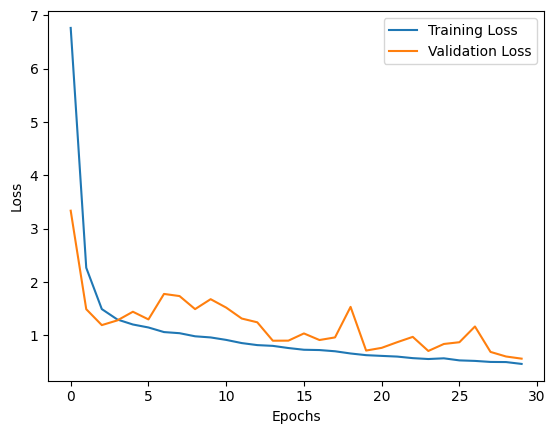

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_results = model.evaluate(tf_dataset_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


230/230 [==============================] - 25s 108ms/step - loss: 0.8181 - accuracy: 0.8620
Test Loss: 0.8180822730064392
Test Accuracy: 0.8620408177375793


F1, precision, recall for Test set


In [ ]:
y_pred = model.predict(tf_dataset_test)
# y_true = tf.concat([y for _, y in tf_dataset_test], axis=0)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_pred_classes_flat = y_pred_classes.flatten()


true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, y_pred_classes_flat)
print("F1, precision, recall for Test set")
print(report)

230/230 [==============================] - 25s 106ms/step
F1, precision, recall for Test set
              precision    recall  f1-score   support

           0       0.39      0.44      0.41      2835
           1       0.62      0.56      0.59      4515

    accuracy                           0.51      7350
   macro avg       0.50      0.50      0.50      7350
weighted avg       0.53      0.51      0.52      7350



F1, precision, recall for Train set


In [ ]:
################ F1, precision, recall for Train set ####################
y_pred = model.predict(tf_dataset_train_combined)
# y_true = tf.concat([y for _, y in tf_dataset_test], axis=0)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_pred_classes_flat = y_pred_classes.flatten()

true_labels = []
for images, labels in tf_dataset_train_combined.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, y_pred_classes_flat)
print("F1, precision, recall for Training set")
print(report)

704/704 [==============================] - 78s 110ms/step
F1, precision, recall for Training set
              precision    recall  f1-score   support

           0       0.39      0.63      0.48      8818
           1       0.61      0.38      0.47     13692

    accuracy                           0.48     22510
   macro avg       0.50      0.50      0.48     22510
weighted avg       0.53      0.48      0.47     22510



F1, precision, recall for Validation set

In [ ]:
################ F1, precision, recall for Validation set ####################
y_pred = model.predict(tf_dataset_val)
# y_true = tf.concat([y for _, y in tf_dataset_test], axis=0)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_pred_classes_flat = y_pred_classes.flatten()

true_labels = []
for images, labels in tf_dataset_val.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, y_pred_classes_flat)
print("F1, precision, recall for Validation set")
print(report)

186/186 [==============================] - 20s 108ms/step
F1, precision, recall for Validation set
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      3890
           1       0.33      0.33      0.33      2059

    accuracy                           0.54      5949
   macro avg       0.49      0.49      0.49      5949
weighted avg       0.54      0.54      0.54      5949



1. (d) Transfer learning


I am using the same augmented dataset which I used for CNN+MLP. The batch size remains as 64.

A. EfficientNetB0

In [ ]:

base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model_efficientnet.layers:
    layer.trainable = False


# model_efficientnet = Sequential([
#     base_model_efficientnet,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     # Dropout(0.3),
#     Dense(512, activation='relu'),
#     Dropout(0.3),
#     Dense(2, activation='softmax')
# ])

model_efficientnet = Sequential([
    base_model_efficientnet,
    GlobalAveragePooling2D(),
    # BatchNormalization(),
    # Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_efficientnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
#barch_size = 8
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_efficientnet.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(tf_dataset_train_combined, epochs=25, validation_data=(tf_dataset_val), callbacks=[early_stop], verbose=1)

history_efficientnet = model_efficientnet.fit(tf_dataset_train_combined,
    epochs=15,
    validation_data=tf_dataset_val,
    callbacks=[early_stop])

Epoch 1/15
704/704 [==============================] - 184s 252ms/step - loss: 0.6738 - accuracy: 0.6062 - val_loss: 0.7658 - val_accuracy: 0.3461
Epoch 2/15
704/704 [==============================] - 174s 247ms/step - loss: 0.6743 - accuracy: 0.6073 - val_loss: 0.7473 - val_accuracy: 0.3461
Epoch 3/15
704/704 [==============================] - 174s 247ms/step - loss: 0.6729 - accuracy: 0.6063 - val_loss: 0.7630 - val_accuracy: 0.3461
Epoch 4/15
704/704 [==============================] - 175s 248ms/step - loss: 0.6731 - accuracy: 0.6073 - val_loss: 0.7716 - val_accuracy: 0.3461
Epoch 5/15
704/704 [==============================] - 174s 248ms/step - loss: 0.6739 - accuracy: 0.6033 - val_loss: 0.7528 - val_accuracy: 0.3461
Epoch 6/15
704/704 [==============================] - 175s 248ms/step - loss: 0.6729 - accuracy: 0.6069 - val_loss: 0.7573 - val_accuracy: 0.3461
Epoch 7/15
704/704 [==============================] - 174s 247ms/step - loss: 0.6723 - accuracy: 0.6063 - val_loss: 0.7613 -

Results for EfficientNetB0

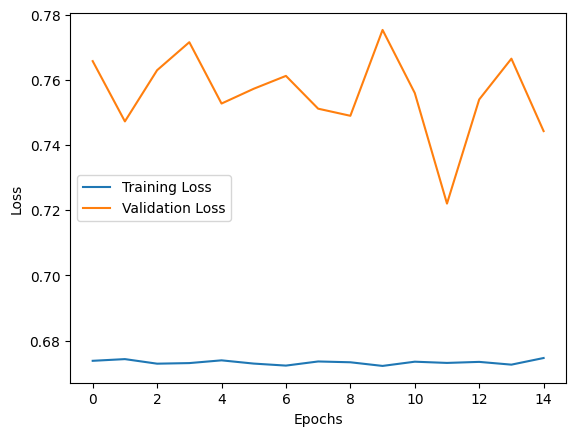

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_results_EN = model_efficientnet.evaluate(tf_dataset_test)
print("Test Loss:", test_results_EN[0])
print("Test Accuracy:", test_results_EN[1])


230/230 [==============================] - 44s 190ms/step - loss: 0.6712 - accuracy: 0.6143
Test Loss: 0.6711567044258118
Test Accuracy: 0.6142857074737549


F1 score, precision and recall for Testing data

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred_EN = model_efficientnet.predict(tf_dataset_test)
y_pred_EN_classes = np.argmax(y_pred_EN, axis=1)

# y_pred_EN_classes = tf.argmax(y_pred_EN, axis=1).numpy()
y_pred_EN_classes_flat = y_pred_EN_classes.flatten()

true_labels_EN = []
# for images, labels in tf_dataset_test.unbatch():
#     true_labels_EN.append(labels.numpy())

true_labels_EN = np.concatenate([y for x, y in tf_dataset_test.unbatch().batch(batch_size)], axis=0)


# true_labels_EN = np.array(true_labels_EN)
true_labels_EN_flat = true_labels_EN.flatten()

report_EN = classification_report(true_labels_EN_flat, y_pred_EN_classes_flat)
print("F1 score, precision and recall for Testing data")
print(report_EN)
# print(true_labels_EN)

# y_true = tf.concat([y for _, y in tf_dataset_test], axis=0)

# Convert probabilities to class predictions

230/230 [==============================] - 45s 188ms/step
F1 score, precision and recall for Testing data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2835
           1       0.61      1.00      0.76      4515

    accuracy                           0.61      7350
   macro avg       0.31      0.50      0.38      7350
weighted avg       0.38      0.61      0.47      7350



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score, precision and recall for Training data

In [ ]:

y_pred_EN = model_efficientnet.predict(tf_dataset_train_combined)
y_pred_EN_classes = np.argmax(y_pred_EN, axis=1)

# y_pred_EN_classes = tf.argmax(y_pred_EN, axis=1).numpy()
y_pred_EN_classes_flat = y_pred_EN_classes.flatten()

true_labels_EN = []
# for images, labels in tf_dataset_test.unbatch():
#     true_labels_EN.append(labels.numpy())

true_labels_EN = np.concatenate([y for x, y in tf_dataset_train_combined.unbatch().batch(batch_size)], axis=0)


# true_labels_EN = np.array(true_labels_EN)
true_labels_EN_flat = true_labels_EN.flatten()

report_EN = classification_report(true_labels_EN_flat, y_pred_EN_classes_flat)
print("F1 score, precision and recall for Training data")
print(report_EN)
# print(true_labels_EN)

# precision, recall, f1, _ = precision_recall_fscore_support(true_labels_EN_flat, y_pred_EN_classes_flat, average='macro')

# y_true = tf.concat([y for _, y in tf_dataset_test], axis=0)

# Convert probabilities to class predictions

704/704 [==============================] - 137s 194ms/step
F1 score, precision and recall for Training data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8821
           1       0.61      1.00      0.76     13689

    accuracy                           0.61     22510
   macro avg       0.30      0.50      0.38     22510
weighted avg       0.37      0.61      0.46     22510



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score, precision and recall for Validation data

In [ ]:

y_pred_EN = model_efficientnet.predict(tf_dataset_val)
y_pred_EN_classes = np.argmax(y_pred_EN, axis=1)

y_pred_EN_classes_flat = y_pred_EN_classes.flatten()

true_labels_EN = []
true_labels_EN = np.concatenate([y for x, y in tf_dataset_val.unbatch().batch(batch_size)], axis=0)
true_labels_EN_flat = true_labels_EN.flatten()

report_EN = classification_report(true_labels_EN_flat, y_pred_EN_classes_flat)
print("F1 score, precision and recall for Validation data")
print(report_EN)


186/186 [==============================] - 35s 187ms/step
F1 score, precision and recall for Validation data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3890
           1       0.35      1.00      0.51      2059

    accuracy                           0.35      5949
   macro avg       0.17      0.50      0.26      5949
weighted avg       0.12      0.35      0.18      5949



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


B. ResNet50

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
for layer in base_model_resnet.layers:
    layer.trainable = False


# model_efficientnet = Sequential([
#     base_model_efficientnet,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     # Dropout(0.3),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(2, activation='softmax')
# ])

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    # BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])



In [ ]:
model_resnet.compile(optimizer=Adam(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_resnet = model_resnet.fit(tf_dataset_train_combined,
    epochs=15,
    validation_data=tf_dataset_val,
    callbacks=[early_stop])

Epoch 1/15
704/704 [==============================] - 227s 318ms/step - loss: 0.5477 - accuracy: 0.7637 - val_loss: 1.1792 - val_accuracy: 0.7073
Epoch 2/15
704/704 [==============================] - 225s 319ms/step - loss: 0.4929 - accuracy: 0.7841 - val_loss: 2.3288 - val_accuracy: 0.3461
Epoch 3/15
704/704 [==============================] - 225s 319ms/step - loss: 0.5511 - accuracy: 0.7743 - val_loss: 6.1145 - val_accuracy: 0.3461
Epoch 4/15
704/704 [==============================] - 225s 319ms/step - loss: 0.5144 - accuracy: 0.7873 - val_loss: 6.1063 - val_accuracy: 0.6539
Epoch 5/15
704/704 [==============================] - 225s 320ms/step - loss: 0.4777 - accuracy: 0.7928 - val_loss: 5.6139 - val_accuracy: 0.3461
Epoch 6/15
704/704 [==============================] - 226s 320ms/step - loss: 0.4644 - accuracy: 0.8006 - val_loss: 0.3110 - val_accuracy: 0.8496
Epoch 7/15
704/704 [==============================] - 225s 320ms/step - loss: 0.4701 - accuracy: 0.8023 - val_loss: 2.8376 -

Results for ResNet50

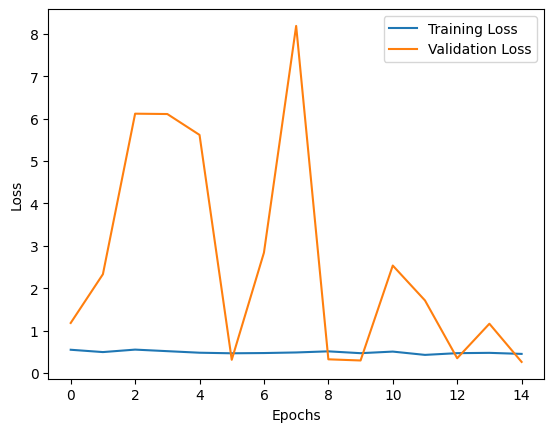

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_results_EN = model_resnet.evaluate(tf_dataset_test)
print("Test Loss:", test_results_EN[0])
print("Test Accuracy:", test_results_EN[1])

230/230 [==============================] - 58s 250ms/step - loss: 0.5533 - accuracy: 0.7410
Test Loss: 0.5533331036567688
Test Accuracy: 0.7409523725509644


v. Report Precision, Recall, and F1 score for your model.

F1 score, precision and recall for Testing data

In [ ]:
y_pred_RN = model_resnet.predict(tf_dataset_test)
y_pred_RN_classes = tf.argmax(y_pred_RN, axis=1).numpy()
y_pred_RN_classes_flat = y_pred_RN_classes.flatten()

true_labels_RN = []
for images, labels in tf_dataset_test.unbatch():
    true_labels_RN.append(labels.numpy())

true_labels_RN = np.array(true_labels_RN)
true_labels_RN_flat = true_labels_RN.flatten()

report_RN = classification_report(true_labels_RN_flat, y_pred_RN_classes_flat)
print("F1 score, precision and recall for Testing data")
print(report_RN)


230/230 [==============================] - 58s 249ms/step
F1 score, precision and recall for Testing data
              precision    recall  f1-score   support

           0       0.39      0.63      0.48      2835
           1       0.62      0.37      0.46      4515

    accuracy                           0.47      7350
   macro avg       0.50      0.50      0.47      7350
weighted avg       0.53      0.47      0.47      7350



F1 score, precision and recall for training data

In [ ]:
y_pred_RN = model_resnet.predict(tf_dataset_train_combined)
y_pred_RN_classes = tf.argmax(y_pred_RN, axis=1).numpy()
y_pred_RN_classes_flat = y_pred_RN_classes.flatten()

true_labels_RN = []
for images, labels in tf_dataset_train_combined.unbatch():
    true_labels_RN.append(labels.numpy())

true_labels_RN = np.array(true_labels_RN)
true_labels_RN_flat = true_labels_RN.flatten()

report_RN = classification_report(true_labels_RN_flat, y_pred_RN_classes_flat)
print("F1 score, precision and recall for training data")
print(report_RN)


704/704 [==============================] - 178s 253ms/step
F1 score, precision and recall for training data
              precision    recall  f1-score   support

           0       0.39      0.88      0.54      8821
           1       0.62      0.13      0.21     13689

    accuracy                           0.42     22510
   macro avg       0.51      0.50      0.38     22510
weighted avg       0.53      0.42      0.34     22510



F1 score, precision and recall for Valdidation data

In [ ]:
y_pred_RN = model_resnet.predict(tf_dataset_val)
y_pred_RN_classes = tf.argmax(y_pred_RN, axis=1).numpy()
y_pred_RN_classes_flat = y_pred_RN_classes.flatten()

true_labels_RN = []
for images, labels in tf_dataset_val.unbatch():
    true_labels_RN.append(labels.numpy())

true_labels_RN = np.array(true_labels_RN)
true_labels_RN_flat = true_labels_RN.flatten()

report_RN = classification_report(true_labels_RN_flat, y_pred_RN_classes_flat)
print("F1 score, precision and recall for Valdidation data")
print(report_RN)


186/186 [==============================] - 46s 247ms/step
F1 score, precision and recall for Valdidation data
              precision    recall  f1-score   support

           0       0.66      0.76      0.70      3890
           1       0.36      0.25      0.30      2059

    accuracy                           0.58      5949
   macro avg       0.51      0.51      0.50      5949
weighted avg       0.55      0.58      0.56      5949



C. VGG16

In [ ]:
# VGG16
base_model_vgg = VGG16(weights='imagenet', include_top=False)
for layer in base_model_vgg.layers:
    layer.trainable = False

model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    # BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


In [ ]:
model_vgg.compile(optimizer=Adam(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_vgg = model_vgg.fit(tf_dataset_train_combined,
    epochs=15,
    validation_data=tf_dataset_val,
    callbacks=[early_stop])

Epoch 1/15
704/704 [==============================] - 289s 408ms/step - loss: 0.3830 - accuracy: 0.8641 - val_loss: 1.0842 - val_accuracy: 0.7753
Epoch 2/15
704/704 [==============================] - 287s 407ms/step - loss: 0.2854 - accuracy: 0.8915 - val_loss: 1.2826 - val_accuracy: 0.7411
Epoch 3/15
704/704 [==============================] - 286s 406ms/step - loss: 0.3440 - accuracy: 0.8844 - val_loss: 2.5584 - val_accuracy: 0.5786
Epoch 4/15
704/704 [==============================] - 284s 403ms/step - loss: 0.3836 - accuracy: 0.8907 - val_loss: 2.5187 - val_accuracy: 0.5947
Epoch 5/15
704/704 [==============================] - 283s 402ms/step - loss: 0.3154 - accuracy: 0.8963 - val_loss: 3.2029 - val_accuracy: 0.4786
Epoch 6/15
704/704 [==============================] - 283s 402ms/step - loss: 0.2726 - accuracy: 0.9021 - val_loss: 1.0032 - val_accuracy: 0.8294
Epoch 7/15
704/704 [==============================] - 283s 401ms/step - loss: 0.3724 - accuracy: 0.8954 - val_loss: 2.6272 -

Results for VGG16

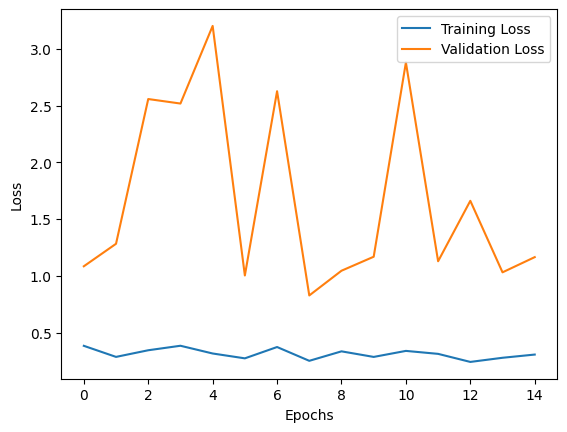

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_results_EN = model_vgg.evaluate(tf_dataset_test)
print("Test Loss:", test_results_EN[0])
print("Test Accuracy:", test_results_EN[1])

230/230 [==============================] - 73s 318ms/step - loss: 0.2421 - accuracy: 0.8830
Test Loss: 0.24208226799964905
Test Accuracy: 0.882993221282959


v. Report Precision, Recall, and F1 score for your model.

F1 score, precision and recall for Testing data

In [ ]:
y_pred_VGG = model_vgg.predict(tf_dataset_test)
y_pred_VGG_classes = tf.argmax(y_pred_VGG, axis=1).numpy()
y_pred_VGG_classes_flat = y_pred_VGG_classes.flatten()

true_labels_VGG = []
for images, labels in tf_dataset_test.unbatch():
    true_labels_VGG.append(labels.numpy())

true_labels_VGG = np.array(true_labels_VGG)
true_labels_VGG_flat = true_labels_VGG.flatten()

report_VGG = classification_report(true_labels_VGG_flat, y_pred_VGG_classes_flat)
print("F1 score, precision and recall for Testing data")
print(report_VGG)


230/230 [==============================] - 73s 314ms/step
F1 score, precision and recall for Testing data
              precision    recall  f1-score   support

           0       0.41      0.29      0.34      2835
           1       0.62      0.73      0.67      4515

    accuracy                           0.56      7350
   macro avg       0.51      0.51      0.51      7350
weighted avg       0.54      0.56      0.54      7350



F1 score, precision and recall for Training data

In [ ]:
y_pred_VGG = model_vgg.predict(tf_dataset_train_combined)
y_pred_VGG_classes = tf.argmax(y_pred_VGG, axis=1).numpy()
y_pred_VGG_classes_flat = y_pred_VGG_classes.flatten()

true_labels_VGG = []
for images, labels in tf_dataset_train_combined.unbatch():
    true_labels_VGG.append(labels.numpy())

true_labels_VGG = np.array(true_labels_VGG)
true_labels_VGG_flat = true_labels_VGG.flatten()

report_VGG = classification_report(true_labels_VGG_flat, y_pred_VGG_classes_flat)
print("F1 score, precision and recall for Training data")
print(report_VGG)


704/704 [==============================] - 224s 317ms/step
F1 score, precision and recall for Training data
              precision    recall  f1-score   support

           0       0.39      0.27      0.32      8821
           1       0.61      0.73      0.66     13689

    accuracy                           0.55     22510
   macro avg       0.50      0.50      0.49     22510
weighted avg       0.52      0.55      0.53     22510



F1 score, precision and recall for Validation data

In [ ]:
y_pred_VGG = model_vgg.predict(tf_dataset_val)
y_pred_VGG_classes = tf.argmax(y_pred_VGG, axis=1).numpy()
y_pred_VGG_classes_flat = y_pred_VGG_classes.flatten()

true_labels_VGG = []
for images, labels in tf_dataset_val.unbatch():
    true_labels_VGG.append(labels.numpy())

true_labels_VGG = np.array(true_labels_VGG)
true_labels_VGG_flat = true_labels_VGG.flatten()

report_VGG = classification_report(true_labels_VGG_flat, y_pred_VGG_classes_flat)
print("F1 score, precision and recall for Validation data")
print(report_VGG)


186/186 [==============================] - 59s 314ms/step
F1 score, precision and recall for Validation data
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      3890
           1       0.34      0.67      0.45      2059

    accuracy                           0.44      5949
   macro avg       0.50      0.50      0.44      5949
weighted avg       0.54      0.44      0.44      5949



## vi. Compare the results of transfer learning with those of CNN + MLP model and explain them.

### Training and validation errors vs. epochs

#### CNN + MLP
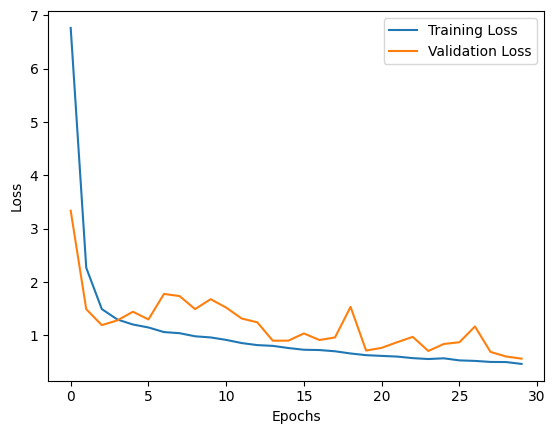

#### EfficientNetB0
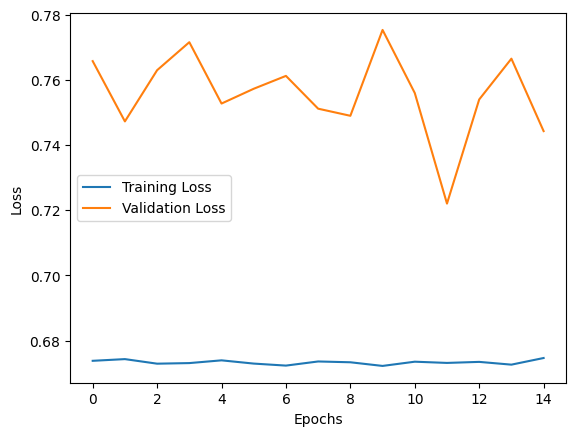


#### ResNet50
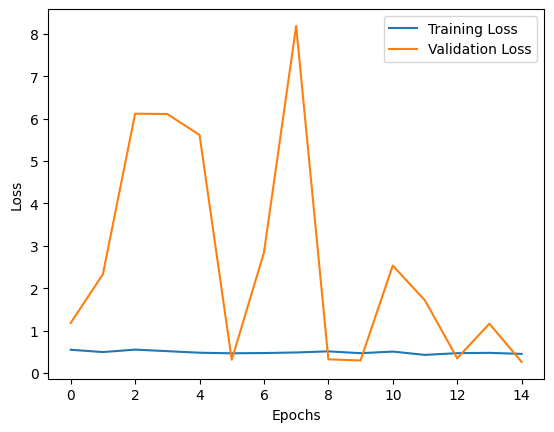


#### VGG16
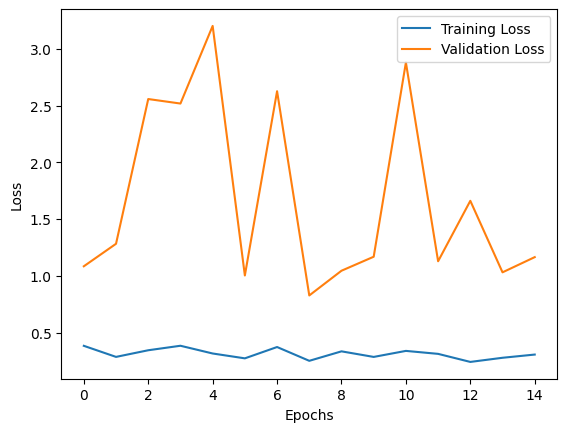

### Comparison: Training and validation errors vs. epochs

1. CNN - MLP: The training loss seems to gradually decrease and the validation loss almost consistently seems to decrease along the training loss, which says that it can generalize better.

2. EfficientNetB0: The training loss seems to have very less changes, and is always around the same value. The validation loss increases and decreases drastically here, and we see a lot of flunctuations.

3. ResNet50: The training loss seems to have very less changes, and is always around the same value. The validation loss increases and decreases drastically here, and we see a lot of flunctuations. But towards the end of our set number of epochs, the validation loss does decrease significantly.

4. VGG16: The training loss seems to have very less changes, and is always around the same value. The validation loss increases and decreases drastically here, we see a lot of flunctuations. And the validation loss is quite high.


Although we see such kind of behaviour in these models, we haven't run them for longer/higher number of epochs. So if we keep training them for higher number of epochs, they might or not show improvement in terms of validation/training loss.

### Precision, Recall, F1 score, Test Accuracy

#### For CNN + MLP:

Test Accuracy: 0.8620408177375793

F1, precision, recall for Test set

              precision    recall  f1-score   support

           0       0.39      0.44      0.41      2835
           1       0.62      0.56      0.59      4515

    accuracy                           0.51      7350
    macro avg       0.50      0.50     0.50      7350
    weighted avg    0.53      0.51     0.52      7350




#### For EfficientNetB0:

Test Accuracy: 0.6142857074737549

F1 score, precision and recall for Testing data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2835
           1       0.61      1.00      0.76      4515

    accuracy                            0.61      7350
    macro avg       0.31      0.50      0.38      7350
    weighted avg    0.38      0.61      0.47      7350

#### For ResNet50:

Test Accuracy: 0.7409523725509644


F1 score, precision and recall for Testing data

              precision    recall  f1-score   support

           0       0.39      0.63      0.48      2835
           1       0.62      0.37      0.46      4515

    accuracy                           0.47      7350
    macro avg      0.50      0.50      0.47      7350
    weighted avg   0.53      0.47      0.47      7350

#### For VGG16:

Test Accuracy: 0.882993221282959


F1 score, precision and recall for Testing data

              precision    recall  f1-score   support

           0       0.41      0.29      0.34      2835
           1       0.62      0.73      0.67      4515

    accuracy                           0.56      7350
    macro avg       0.51      0.51     0.51      7350
    weighted avg    0.54      0.56     0.54      7350

### Comparison: Test Accuracy
We can see that we get the highest test accuracy for VGG16 out of the 4 models. It is followed by the CNN + MLP model, which seems to have an ability to generalize better. And then it's followed by ResNet50 and EfficientNetB0.

### Comparison: Precision, recall, F1 score

1. CNN + MLP has moderate precision and recall for both classes, with relatively balanced performance.

2. EfficientNetB0 performs well in identifying Class 1 data but poorly in identifying Class 0 data (precision = 0, recall = 0.) EfficientNetB0 has a high F1 score for Class 1 but performs poorly for Class 0, where its F1 score is 0.00.

3. ResNet50 has better recall for Class 0 but struggles with precision for Class 1.

4. VGG16 has higher precision, and recall for Class 1 but relatively lower precision and recall for Class 0. VGG16 has a higher F1 score for Class 1 but a lower one for Class 0.